In [2]:
import tensorflow as tf
import os, re, glob
import cv2
import importlib
import numpy as np
from os import listdir
from os.path import isfile, join
from PIL import Image
from datetime import datetime

import tensorflow.keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import itertools

origin_dir="D:/GTdb_crop/cropped_faces"
resized_dir="D:/GTdb_crop/resized_faces"
tr_labels = []
v_labels = []
te_labels = []
# data 크기 16x16, 32x32, 64x64로 조절, 각각 원본, 흑백 버전으로 나눠 저장.
# train, validation, test용으로 나눠 저장.
# (train: 66% - 그중 1개씩 validation / test: 34%)

for i in range (1, 51):
    for j in range (1, 16):
        k=str(i)
        z=str(j)
        sizes = [16, 32, 64]
        for s in sizes:
            ss=str(s)
            if (i<10 and j<10):
                img = Image.open(origin_dir+"/"+"s0"+k+"_0"+z+".jpg")
                img_resize=img.resize((s,s))
                img_resize.save(resized_dir+"/train_img/train_"+ss+"_3/"+"s0"+k+"_0"+z+"_"+ss+"x"+ss+"x3.jpg")
                img_gray=img_resize.convert('L')
                img_gray.save(resized_dir+"/train_img/train_"+ss+"_1/"+"s0"+k+"_0"+z+"_"+ss+"x"+ss+"x1.jpg")
                if s==16:
                    tr_labels.append(i-1)
            elif (i<10 and j>=10):
                img = Image.open(origin_dir+"/"+"s0"+k+"_"+z+".jpg")
                img_resize=img.resize((s,s))
                if j==10:
                    img_resize.save(resized_dir+"/vali_img/vali_"+ss+"_3/"+"s0"+k+"_"+z+"_"+ss+"x"+ss+"x3.jpg")
                    img_gray=img_resize.convert('L')
                    img_gray.save(resized_dir+"/vali_img/vali_"+ss+"_1/"+"s0"+k+"_"+z+"_"+ss+"x"+ss+"x1.jpg")
                    if s==16:
                        v_labels.append(i-1)
                else:
                    img_resize.save(resized_dir+"/test_img/test_"+ss+"_3/"+"s0"+k+"_"+z+"_"+ss+"x"+ss+"x3.jpg")
                    img_gray=img_resize.convert('L')
                    img_gray.save(resized_dir+"/test_img/test_"+ss+"_1/"+"s0"+k+"_"+z+"_"+ss+"x"+ss+"x1.jpg")
                    if s==16:
                        te_labels.append(i-1)
            elif (i>=10 and j<10):
                img = Image.open(origin_dir+"/"+"s"+k+"_0"+z+".jpg")
                img_resize=img.resize((s,s))
                img_resize.save(resized_dir+"/train_img/train_"+ss+"_3/"+"s"+k+"_0"+z+"_"+ss+"x"+ss+"x3.jpg")
                img_gray=img_resize.convert('L')
                img_gray.save(resized_dir+"/train_img/train_"+ss+"_1/"+"s"+k+"_0"+z+"_"+ss+"x"+ss+"x1.jpg")
                if s==16:
                    tr_labels.append(i-1)
            else:
                img = Image.open(origin_dir+"/"+"s"+k+"_"+z+".jpg")
                img_resize=img.resize((s,s))
                if j==10:
                    img_resize.save(resized_dir+"/vali_img/vali_"+ss+"_3/"+"s"+k+"_"+z+"_"+ss+"x"+ss+"x3.jpg")
                    img_gray=img_resize.convert('L')
                    img_gray.save(resized_dir+"/vali_img/vali_"+ss+"_1/"+"s"+k+"_"+z+"_"+ss+"x"+ss+"x1.jpg")
                    if s==16:
                        v_labels.append(i-1)
                else:
                    img_resize.save(resized_dir+"/test_img/test_"+ss+"_3/"+"s"+k+"_"+z+"_"+ss+"x"+ss+"x3.jpg")
                    img_gray=img_resize.convert('L')
                    img_gray.save(resized_dir+"/test_img/test_"+ss+"_1/"+"s"+k+"_"+z+"_"+ss+"x"+ss+"x1.jpg")
                    if s==16:
                        te_labels.append(i-1)
                    

In [3]:
# train, validation, test 이미지들 정리해서 numpy array에 담기, labeling
tr64_3_data_dir = 'D:/GTdb_crop/resized_faces/train_img/train_64_3/'
v64_3_data_dir='D:/GTdb_crop/resized_faces/vali_img/vali_64_3/'
te64_3_data_dir='D:/GTdb_crop/resized_faces/test_img/test_64_3/'

tr64_1_data_dir = 'D:/GTdb_crop/resized_faces/train_img/train_64_1/'
v64_1_data_dir='D:/GTdb_crop/resized_faces/vali_img/vali_64_1/'
te64_1_data_dir='D:/GTdb_crop/resized_faces/test_img/test_64_1/'

tr32_3_data_dir = 'D:/GTdb_crop/resized_faces/train_img/train_32_3/'
v32_3_data_dir='D:/GTdb_crop/resized_faces/vali_img/vali_32_3/'
te32_3_data_dir='D:/GTdb_crop/resized_faces/test_img/test_32_3/'

tr32_1_data_dir = 'D:/GTdb_crop/resized_faces/train_img/train_32_1/'
v32_1_data_dir='D:/GTdb_crop/resized_faces/vali_img/vali_32_1/'
te32_1_data_dir='D:/GTdb_crop/resized_faces/test_img/test_32_1/'

tr16_3_data_dir = 'D:/GTdb_crop/resized_faces/train_img/train_16_3/'
v16_3_data_dir='D:/GTdb_crop/resized_faces/vali_img/vali_16_3/'
te16_3_data_dir='D:/GTdb_crop/resized_faces/test_img/test_16_3/'

tr16_1_data_dir = 'D:/GTdb_crop/resized_faces/train_img/train_16_1/'
v16_1_data_dir='D:/GTdb_crop/resized_faces/vali_img/vali_16_1/'
te16_1_data_dir='D:/GTdb_crop/resized_faces/test_img/test_16_1/'


only_tr64_3_files = [f for f in listdir(tr64_3_data_dir) if isfile(join(tr64_3_data_dir, f))]
only_v64_3_files = [f for f in listdir(v64_3_data_dir) if isfile(join(v64_3_data_dir, f))]
only_te64_3_files = [f for f in listdir(te64_3_data_dir) if isfile(join(te64_3_data_dir, f))]

only_tr64_1_files = [f for f in listdir(tr64_1_data_dir) if isfile(join(tr64_1_data_dir, f))]
only_v64_1_files = [f for f in listdir(v64_1_data_dir) if isfile(join(v64_1_data_dir, f))]
only_te64_1_files = [f for f in listdir(te64_1_data_dir) if isfile(join(te64_1_data_dir, f))]

only_tr32_3_files = [f for f in listdir(tr32_3_data_dir) if isfile(join(tr32_3_data_dir, f))]
only_v32_3_files = [f for f in listdir(v32_3_data_dir) if isfile(join(v32_3_data_dir, f))]
only_te32_3_files = [f for f in listdir(te32_3_data_dir) if isfile(join(te32_3_data_dir, f))]

only_tr32_1_files = [f for f in listdir(tr32_1_data_dir) if isfile(join(tr32_1_data_dir, f))]
only_v32_1_files = [f for f in listdir(v32_1_data_dir) if isfile(join(v32_1_data_dir, f))]
only_te32_1_files = [f for f in listdir(te32_1_data_dir) if isfile(join(te32_1_data_dir, f))]

only_tr16_3_files = [f for f in listdir(tr16_3_data_dir) if isfile(join(tr16_3_data_dir, f))]
only_v16_3_files = [f for f in listdir(v16_3_data_dir) if isfile(join(v16_3_data_dir, f))]
only_te16_3_files = [f for f in listdir(te16_3_data_dir) if isfile(join(te16_3_data_dir, f))]

only_tr16_1_files = [f for f in listdir(tr16_1_data_dir) if isfile(join(tr16_1_data_dir, f))]
only_v16_1_files = [f for f in listdir(v16_1_data_dir) if isfile(join(v16_1_data_dir, f))]
only_te16_1_files = [f for f in listdir(te16_1_data_dir) if isfile(join(te16_1_data_dir, f))]


training64_3_img = []
valid64_3_img= []
testing64_3_img = []

training64_1_img = []
valid64_1_img= []
testing64_1_img = []

training32_3_img = []
valid32_3_img= []
testing32_3_img = []

training32_1_img = []
valid32_1_img= []
testing32_1_img = []

training16_3_img = []
valid16_3_img= []
testing16_3_img = []

training16_1_img = []
valid16_1_img= []
testing16_1_img = []


for i, files in enumerate(only_tr64_3_files):
    tr_img_dir=tr64_3_data_dir+only_tr64_3_files[i]
    tr_imgs=cv2.imread(tr_img_dir)
    if tr_imgs is None:
        continue
    training64_3_img.append(np.asarray(tr_imgs, dtype=np.uint8))
for i, files in enumerate(only_tr64_1_files):
    tr_img_dir=tr64_1_data_dir+only_tr64_1_files[i]
    tr_imgs=cv2.imread(tr_img_dir, cv2.IMREAD_GRAYSCALE)
    if tr_imgs is None:
        continue
    training64_1_img.append(np.asarray(tr_imgs, dtype=np.uint8))
for i, files in enumerate(only_tr32_3_files):
    tr_img_dir=tr32_3_data_dir+only_tr32_3_files[i]
    tr_imgs=cv2.imread(tr_img_dir)
    if tr_imgs is None:
        continue
    training32_3_img.append(np.asarray(tr_imgs, dtype=np.uint8))
for i, files in enumerate(only_tr32_1_files):
    tr_img_dir=tr32_1_data_dir+only_tr32_1_files[i]
    tr_imgs=cv2.imread(tr_img_dir, cv2.IMREAD_GRAYSCALE)
    if tr_imgs is None:
        continue
    training32_1_img.append(np.asarray(tr_imgs, dtype=np.uint8))
for i, files in enumerate(only_tr16_3_files):
    tr_img_dir=tr16_3_data_dir+only_tr16_3_files[i]
    tr_imgs=cv2.imread(tr_img_dir)
    if tr_imgs is None:
        continue
    training16_3_img.append(np.asarray(tr_imgs, dtype=np.uint8))
for i, files in enumerate(only_tr16_1_files):
    tr_img_dir=tr16_1_data_dir+only_tr16_1_files[i]
    tr_imgs=cv2.imread(tr_img_dir, cv2.IMREAD_GRAYSCALE)
    if tr_imgs is None:
        continue
    training16_1_img.append(np.asarray(tr_imgs, dtype=np.uint8))
    
for i, files in enumerate(only_v64_3_files):
    v_img_dir=v64_3_data_dir+only_v64_3_files[i]
    v_imgs=cv2.imread(v_img_dir)
    if v_imgs is None:
        continue
    valid64_3_img.append(np.asarray(v_imgs, dtype=np.uint8))
for i, files in enumerate(only_v64_1_files):
    v_img_dir=v64_1_data_dir+only_v64_1_files[i]
    v_imgs=cv2.imread(v_img_dir, cv2.IMREAD_GRAYSCALE)
    if v_imgs is None:
        continue
    valid64_1_img.append(np.asarray(v_imgs, dtype=np.uint8))
for i, files in enumerate(only_v32_3_files):
    v_img_dir=v32_3_data_dir+only_v32_3_files[i]
    v_imgs=cv2.imread(v_img_dir)
    if v_imgs is None:
        continue
    valid32_3_img.append(np.asarray(v_imgs, dtype=np.uint8))
for i, files in enumerate(only_v32_1_files):
    v_img_dir=v32_1_data_dir+only_v32_1_files[i]
    v_imgs=cv2.imread(v_img_dir, cv2.IMREAD_GRAYSCALE)
    if v_imgs is None:
        continue
    valid32_1_img.append(np.asarray(v_imgs, dtype=np.uint8))
for i, files in enumerate(only_v16_3_files):
    v_img_dir=v16_3_data_dir+only_v16_3_files[i]
    v_imgs=cv2.imread(v_img_dir)
    if v_imgs is None:
        continue
    valid16_3_img.append(np.asarray(v_imgs, dtype=np.uint8))
for i, files in enumerate(only_v16_1_files):
    v_img_dir=v16_1_data_dir+only_v16_1_files[i]
    v_imgs=cv2.imread(v_img_dir, cv2.IMREAD_GRAYSCALE)
    if v_imgs is None:
        continue
    valid16_1_img.append(np.asarray(v_imgs, dtype=np.uint8))

for i, files in enumerate(only_te64_3_files):
    te_img_dir=te64_3_data_dir+only_te64_3_files[i]
    te_imgs=cv2.imread(te_img_dir)
    if te_imgs is None:
        continue
    testing64_3_img.append(np.asarray(te_imgs, dtype=np.uint8))
for i, files in enumerate(only_te64_1_files):
    te_img_dir=te64_1_data_dir+only_te64_1_files[i]
    te_imgs=cv2.imread(te_img_dir, cv2.IMREAD_GRAYSCALE)
    if te_imgs is None:
        continue
    testing64_1_img.append(np.asarray(te_imgs, dtype=np.uint8))
for i, files in enumerate(only_te32_3_files):
    te_img_dir=te32_3_data_dir+only_te32_3_files[i]
    te_imgs=cv2.imread(te_img_dir)
    if te_imgs is None:
        continue
    testing32_3_img.append(np.asarray(te_imgs, dtype=np.uint8))
for i, files in enumerate(only_te32_1_files):
    te_img_dir=te32_1_data_dir+only_te32_1_files[i]
    te_imgs=cv2.imread(te_img_dir, cv2.IMREAD_GRAYSCALE)
    if te_imgs is None:
        continue
    testing32_1_img.append(np.asarray(te_imgs, dtype=np.uint8))
for i, files in enumerate(only_te16_3_files):
    te_img_dir=te16_3_data_dir+only_te16_3_files[i]
    te_imgs=cv2.imread(te_img_dir)
    if te_imgs is None:
        continue
    testing16_3_img.append(np.asarray(te_imgs, dtype=np.uint8))
for i, files in enumerate(only_te16_1_files):
    te_img_dir=te16_1_data_dir+only_te16_1_files[i]
    te_imgs=cv2.imread(te_img_dir, cv2.IMREAD_GRAYSCALE)
    if te_imgs is None:
        continue
    testing16_1_img.append(np.asarray(te_imgs, dtype=np.uint8))

    
training64_3_img=np.array(training64_3_img)
valid64_3_img=np.array(valid64_3_img)
testing64_3_img=np.array(testing64_3_img)
training64_1_img=np.array(training64_1_img)
valid64_1_img=np.array(valid64_1_img)
testing64_1_img=np.array(testing64_1_img)
training32_3_img=np.array(training32_3_img)
valid32_3_img=np.array(valid32_3_img)
testing32_3_img=np.array(testing32_3_img)
training32_1_img=np.array(training32_1_img)
valid32_1_img=np.array(valid32_1_img)
testing32_1_img=np.array(testing32_1_img)
training16_3_img=np.array(training16_3_img)
valid16_3_img=np.array(valid16_3_img)
testing16_3_img=np.array(testing16_3_img)
training16_1_img=np.array(training16_1_img)
valid16_1_img=np.array(valid16_1_img)
testing16_1_img=np.array(testing16_1_img)

training64_1_img=training64_1_img.reshape((training64_1_img.shape[0], training64_1_img.shape[1], training64_1_img.shape[2], 1))
training32_1_img=training32_1_img.reshape((training32_1_img.shape[0], training32_1_img.shape[1], training32_1_img.shape[2], 1))
training16_1_img=training16_1_img.reshape((training16_1_img.shape[0], training16_1_img.shape[1], training16_1_img.shape[2], 1))
valid64_1_img=valid64_1_img.reshape((valid64_1_img.shape[0], valid64_1_img.shape[1], valid64_1_img.shape[2], 1))
valid32_1_img=valid32_1_img.reshape((valid32_1_img.shape[0], valid32_1_img.shape[1], valid32_1_img.shape[2], 1))
valid16_1_img=valid16_1_img.reshape((valid16_1_img.shape[0], valid16_1_img.shape[1], valid16_1_img.shape[2], 1))
testing64_1_img=testing64_1_img.reshape((testing64_1_img.shape[0], testing64_1_img.shape[1], testing64_1_img.shape[2], 1))
testing32_1_img=testing32_1_img.reshape((testing32_1_img.shape[0], testing32_1_img.shape[1], testing32_1_img.shape[2], 1))
testing16_1_img=testing16_1_img.reshape((testing16_1_img.shape[0], testing16_1_img.shape[1], testing16_1_img.shape[2], 1))

tr_labels=np.array(tr_labels)
v_labels=np.array(v_labels)
te_labels=np.array(te_labels)
tr_labels=to_categorical(tr_labels)
v_labels=to_categorical(v_labels)
te_labels=to_categorical(te_labels)

print(training64_3_img.shape, tr_labels.shape)
print(training64_1_img.shape, tr_labels.shape)
print(training32_3_img.shape, tr_labels.shape)
print(training32_1_img.shape, tr_labels.shape)
print(training16_3_img.shape, tr_labels.shape)
print(training16_1_img.shape, tr_labels.shape)

(450, 64, 64, 3) (450, 50)
(450, 64, 64, 1) (450, 50)
(450, 32, 32, 3) (450, 50)
(450, 32, 32, 1) (450, 50)
(450, 16, 16, 3) (450, 50)
(450, 16, 16, 1) (450, 50)


In [4]:
# training을 위한 CNN
def cnn_model(inputsize):
    model = Sequential()
    model.add(Conv2D(filters=32,
                     kernel_size=(3, 3),
                     strides=(1, 1),
                     padding='same',
                     input_shape=inputsize))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2),
                           strides=(2, 2)))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=32,
                     kernel_size=(3, 3),
                     strides=(1, 1),
                     padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),
                           strides=(2, 2)))
    model.add(Conv2D(filters=32,
                     kernel_size=(3, 3),
                     strides=(1, 1),
                     padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),
                           strides=(2, 2)))
    model.add(Conv2D(filters=32,
                     kernel_size=(3, 3),
                     strides=(1, 1),
                     padding='same'))
    model.add(Conv2D(filters=32,
                     kernel_size=(3, 3),
                     strides=(1, 1),
                     padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(units=50,
                    activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=['accuracy'])

    model.summary()
    return model


In [5]:
model_16x16x1 = cnn_model((16, 16, 1))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
activation (Activation)      (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
activation_1 (Activation)    (None, 8, 8, 32)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
__________

In [6]:
model_16x16x3 = cnn_model((16, 16, 3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 16, 16, 32)        896       
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
activation_3 (Activation)    (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
activation_4 (Activation)    (None, 8, 8, 32)          0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 32)          0         
__________

In [7]:
model_32x32x1 = cnn_model((32, 32, 1))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
activation_6 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 32)          0         
__________

In [8]:
model_32x32x3 = cnn_model((32, 32, 3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
activation_9 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
activation_10 (Activation)   (None, 16, 16, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 32)          0         
__________

In [9]:
model_64x64x1 = cnn_model((64, 64, 1))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization_8 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 32)        0         
__________

In [10]:
model_64x64x3 = cnn_model((64, 64, 3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization_10 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
activation_15 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_16 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 32)        0         
__________

In [11]:
hist_16_1=model_16x16x1.fit(
    training16_1_img, tr_labels, batch_size=10,
    epochs=35, verbose=2,
    validation_data=(valid16_1_img, v_labels),
)

Train on 450 samples, validate on 50 samples
Epoch 1/35
 - 2s - loss: 4.0773 - acc: 0.0267 - val_loss: 3.9714 - val_acc: 0.0200
Epoch 2/35
 - 1s - loss: 2.9953 - acc: 0.2178 - val_loss: 3.5342 - val_acc: 0.0600
Epoch 3/35
 - 1s - loss: 2.1262 - acc: 0.4289 - val_loss: 3.1527 - val_acc: 0.3200
Epoch 4/35
 - 1s - loss: 1.3652 - acc: 0.6533 - val_loss: 2.6773 - val_acc: 0.4800
Epoch 5/35
 - 1s - loss: 0.9246 - acc: 0.8178 - val_loss: 2.2519 - val_acc: 0.5400
Epoch 6/35
 - 1s - loss: 0.5974 - acc: 0.8889 - val_loss: 1.8801 - val_acc: 0.6000
Epoch 7/35
 - 1s - loss: 0.4351 - acc: 0.9467 - val_loss: 1.6270 - val_acc: 0.6400
Epoch 8/35
 - 1s - loss: 0.2890 - acc: 0.9667 - val_loss: 1.3370 - val_acc: 0.7200
Epoch 9/35
 - 1s - loss: 0.1830 - acc: 0.9933 - val_loss: 1.1783 - val_acc: 0.7600
Epoch 10/35
 - 1s - loss: 0.1185 - acc: 0.9978 - val_loss: 1.1777 - val_acc: 0.7200
Epoch 11/35
 - 1s - loss: 0.0962 - acc: 1.0000 - val_loss: 1.0384 - val_acc: 0.7200
Epoch 12/35
 - 1s - loss: 0.0868 - acc: 

In [12]:
hist_16_3=model_16x16x3.fit(
    training16_3_img, tr_labels, batch_size=20,
    epochs=35, verbose=2,
    validation_data=(valid16_3_img, v_labels),
)

Train on 450 samples, validate on 50 samples
Epoch 1/35
 - 1s - loss: 4.0014 - acc: 0.0533 - val_loss: 4.0256 - val_acc: 0.0200
Epoch 2/35
 - 0s - loss: 2.9329 - acc: 0.2533 - val_loss: 3.6840 - val_acc: 0.0400
Epoch 3/35
 - 0s - loss: 1.9403 - acc: 0.5267 - val_loss: 3.4125 - val_acc: 0.2200
Epoch 4/35
 - 1s - loss: 1.2424 - acc: 0.7444 - val_loss: 3.1383 - val_acc: 0.4000
Epoch 5/35
 - 1s - loss: 0.7745 - acc: 0.8733 - val_loss: 2.9800 - val_acc: 0.5000
Epoch 6/35
 - 1s - loss: 0.5318 - acc: 0.9400 - val_loss: 2.7698 - val_acc: 0.5600
Epoch 7/35
 - 0s - loss: 0.3526 - acc: 0.9733 - val_loss: 2.4585 - val_acc: 0.6800
Epoch 8/35
 - 1s - loss: 0.2273 - acc: 0.9933 - val_loss: 2.3031 - val_acc: 0.6800
Epoch 9/35
 - 1s - loss: 0.1506 - acc: 1.0000 - val_loss: 2.0344 - val_acc: 0.7800
Epoch 10/35
 - 1s - loss: 0.1103 - acc: 1.0000 - val_loss: 1.8951 - val_acc: 0.7200
Epoch 11/35
 - 1s - loss: 0.0750 - acc: 1.0000 - val_loss: 1.6814 - val_acc: 0.7400
Epoch 12/35
 - 1s - loss: 0.0601 - acc: 

In [13]:
hist_32_1=model_32x32x1.fit(
    training32_1_img, tr_labels, batch_size=30,
    epochs=35, verbose=2,
    validation_data=(valid32_1_img, v_labels),
)

Train on 450 samples, validate on 50 samples
Epoch 1/35
 - 3s - loss: 4.1897 - acc: 0.0511 - val_loss: 5.8022 - val_acc: 0.0400
Epoch 2/35
 - 2s - loss: 2.9252 - acc: 0.2467 - val_loss: 4.7167 - val_acc: 0.0400
Epoch 3/35
 - 2s - loss: 1.8097 - acc: 0.5267 - val_loss: 3.7535 - val_acc: 0.0800
Epoch 4/35
 - 2s - loss: 1.0414 - acc: 0.7778 - val_loss: 3.3477 - val_acc: 0.1600
Epoch 5/35
 - 2s - loss: 0.6156 - acc: 0.8933 - val_loss: 3.0799 - val_acc: 0.3400
Epoch 6/35
 - 2s - loss: 0.3167 - acc: 0.9667 - val_loss: 2.9634 - val_acc: 0.3800
Epoch 7/35
 - 2s - loss: 0.1730 - acc: 0.9956 - val_loss: 2.7435 - val_acc: 0.4400
Epoch 8/35
 - 2s - loss: 0.1133 - acc: 1.0000 - val_loss: 2.5628 - val_acc: 0.4600
Epoch 9/35
 - 2s - loss: 0.0607 - acc: 1.0000 - val_loss: 2.2893 - val_acc: 0.6200
Epoch 10/35
 - 2s - loss: 0.0463 - acc: 1.0000 - val_loss: 2.1967 - val_acc: 0.6000
Epoch 11/35
 - 2s - loss: 0.0360 - acc: 1.0000 - val_loss: 1.9973 - val_acc: 0.6800
Epoch 12/35
 - 2s - loss: 0.0277 - acc: 

In [14]:
hist_32_3=model_32x32x3.fit(
    training32_3_img, tr_labels, batch_size=20,
    epochs=35, verbose=2,
    validation_data=(valid32_3_img, v_labels),
)

Train on 450 samples, validate on 50 samples
Epoch 1/35
 - 2s - loss: 4.1308 - acc: 0.0844 - val_loss: 6.2624 - val_acc: 0.0200
Epoch 2/35
 - 2s - loss: 2.6027 - acc: 0.3289 - val_loss: 3.2546 - val_acc: 0.2200
Epoch 3/35
 - 2s - loss: 1.3775 - acc: 0.6556 - val_loss: 2.9071 - val_acc: 0.2400
Epoch 4/35
 - 2s - loss: 0.6828 - acc: 0.8644 - val_loss: 2.2096 - val_acc: 0.4600
Epoch 5/35
 - 2s - loss: 0.3527 - acc: 0.9511 - val_loss: 2.2605 - val_acc: 0.3600
Epoch 6/35
 - 2s - loss: 0.1625 - acc: 0.9933 - val_loss: 1.7706 - val_acc: 0.5800
Epoch 7/35
 - 2s - loss: 0.0883 - acc: 1.0000 - val_loss: 1.5186 - val_acc: 0.7000
Epoch 8/35
 - 2s - loss: 0.0588 - acc: 1.0000 - val_loss: 1.2132 - val_acc: 0.8200
Epoch 9/35
 - 2s - loss: 0.0395 - acc: 1.0000 - val_loss: 1.1350 - val_acc: 0.7800
Epoch 10/35
 - 2s - loss: 0.0296 - acc: 1.0000 - val_loss: 0.9391 - val_acc: 0.8600
Epoch 11/35
 - 2s - loss: 0.0209 - acc: 1.0000 - val_loss: 0.9098 - val_acc: 0.8400
Epoch 12/35
 - 2s - loss: 0.0197 - acc: 

In [15]:
hist_64_1=model_64x64x1.fit(
    training64_1_img, tr_labels, batch_size=30,
    epochs=35, verbose=2,
    validation_data=(valid64_1_img, v_labels),
)

Train on 450 samples, validate on 50 samples
Epoch 1/35
 - 7s - loss: 3.9365 - acc: 0.1044 - val_loss: 12.7296 - val_acc: 0.0600
Epoch 2/35
 - 7s - loss: 1.6983 - acc: 0.5778 - val_loss: 5.5249 - val_acc: 0.1400
Epoch 3/35
 - 7s - loss: 0.5920 - acc: 0.9000 - val_loss: 4.2186 - val_acc: 0.1200
Epoch 4/35
 - 7s - loss: 0.2132 - acc: 0.9800 - val_loss: 2.9379 - val_acc: 0.2600
Epoch 5/35
 - 7s - loss: 0.0896 - acc: 0.9933 - val_loss: 2.4999 - val_acc: 0.3600
Epoch 6/35
 - 7s - loss: 0.0433 - acc: 1.0000 - val_loss: 1.9169 - val_acc: 0.4600
Epoch 7/35
 - 7s - loss: 0.0238 - acc: 1.0000 - val_loss: 1.7447 - val_acc: 0.5000
Epoch 8/35
 - 7s - loss: 0.0176 - acc: 1.0000 - val_loss: 1.4529 - val_acc: 0.6600
Epoch 9/35
 - 7s - loss: 0.0140 - acc: 1.0000 - val_loss: 1.2514 - val_acc: 0.7000
Epoch 10/35
 - 7s - loss: 0.0124 - acc: 1.0000 - val_loss: 1.2029 - val_acc: 0.7000
Epoch 11/35
 - 7s - loss: 0.0102 - acc: 1.0000 - val_loss: 1.0533 - val_acc: 0.7600
Epoch 12/35
 - 7s - loss: 0.0084 - acc:

In [16]:
hist_64_3=model_64x64x3.fit(
    training64_3_img, tr_labels, batch_size=10,
    epochs=35, verbose=2,
    validation_data=(valid64_3_img, v_labels),
)

Train on 450 samples, validate on 50 samples
Epoch 1/35
 - 7s - loss: 3.9319 - acc: 0.1644 - val_loss: 7.5735 - val_acc: 0.1400
Epoch 2/35
 - 7s - loss: 1.1477 - acc: 0.6844 - val_loss: 2.1824 - val_acc: 0.5000
Epoch 3/35
 - 7s - loss: 0.3855 - acc: 0.9044 - val_loss: 3.2073 - val_acc: 0.3000
Epoch 4/35
 - 7s - loss: 0.1211 - acc: 0.9778 - val_loss: 0.7719 - val_acc: 0.7600
Epoch 5/35
 - 7s - loss: 0.0350 - acc: 1.0000 - val_loss: 0.6438 - val_acc: 0.8200
Epoch 6/35
 - 8s - loss: 0.0149 - acc: 1.0000 - val_loss: 0.5225 - val_acc: 0.9000
Epoch 7/35
 - 7s - loss: 0.0089 - acc: 1.0000 - val_loss: 0.5081 - val_acc: 0.9000
Epoch 8/35
 - 7s - loss: 0.0084 - acc: 1.0000 - val_loss: 0.5060 - val_acc: 0.8800
Epoch 9/35
 - 7s - loss: 0.0068 - acc: 1.0000 - val_loss: 0.4702 - val_acc: 0.9000
Epoch 10/35
 - 7s - loss: 0.0044 - acc: 1.0000 - val_loss: 0.4264 - val_acc: 0.9200
Epoch 11/35
 - 7s - loss: 0.0042 - acc: 1.0000 - val_loss: 0.4392 - val_acc: 0.9200
Epoch 12/35
 - 7s - loss: 0.0039 - acc: 

In [17]:
score_16_1 = model_16x16x1.evaluate(testing16_1_img, te_labels, verbose=2)
score_16_3 = model_16x16x3.evaluate(testing16_3_img, te_labels, verbose=2)
score_32_1 = model_32x32x1.evaluate(testing32_1_img, te_labels, verbose=2)
score_32_3 = model_32x32x3.evaluate(testing32_3_img, te_labels, verbose=2)
score_64_1 = model_64x64x1.evaluate(testing64_1_img, te_labels, verbose=2)
score_64_3 = model_64x64x3.evaluate(testing64_3_img, te_labels, verbose=2)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


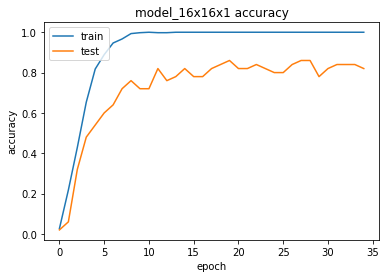

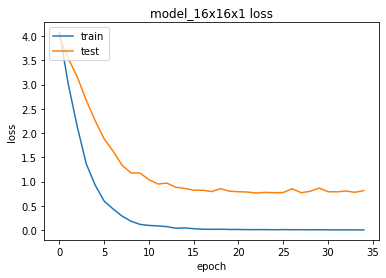

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


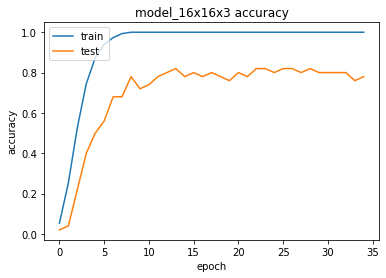

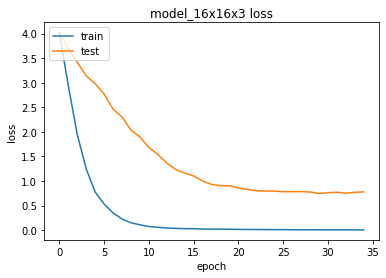

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


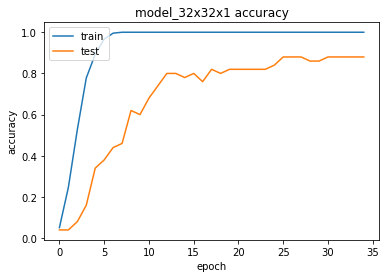

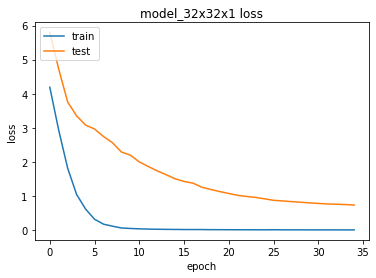

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


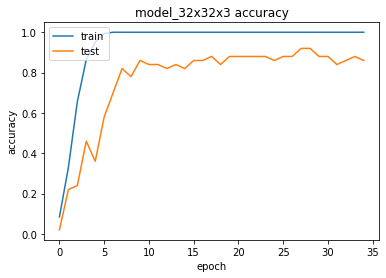

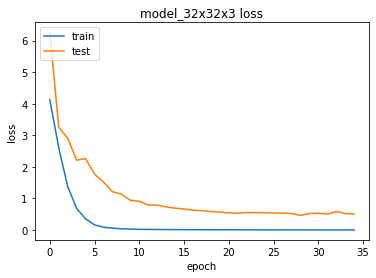

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


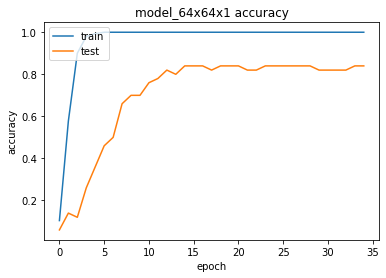

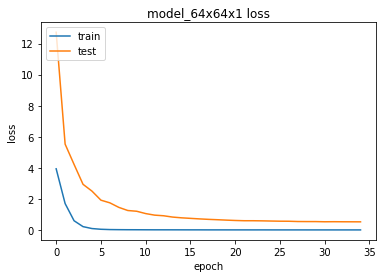

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


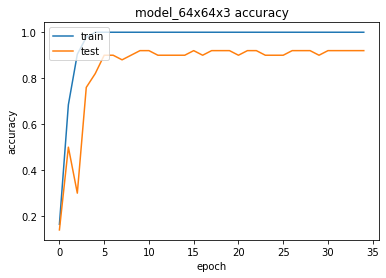

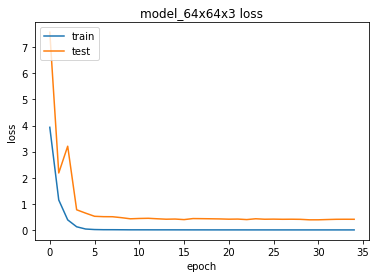

In [19]:
print(hist_16_1.history.keys())
# 16x16x1 accuracy
plt.plot(hist_16_1.history['acc'])
plt.plot(hist_16_1.history['val_acc'])
plt.title('model_16x16x1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# 16x16x1 loss
plt.plot(hist_16_1.history['loss'])
plt.plot(hist_16_1.history['val_loss'])
plt.title('model_16x16x1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print(hist_16_3.history.keys())
# 16x16x3 accuracy
plt.plot(hist_16_3.history['acc'])
plt.plot(hist_16_3.history['val_acc'])
plt.title('model_16x16x3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# 16x16x3 loss
plt.plot(hist_16_3.history['loss'])
plt.plot(hist_16_3.history['val_loss'])
plt.title('model_16x16x3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print(hist_32_1.history.keys())
# 32x32x1 accuracy
plt.plot(hist_32_1.history['acc'])
plt.plot(hist_32_1.history['val_acc'])
plt.title('model_32x32x1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# 32x32x1 loss
plt.plot(hist_32_1.history['loss'])
plt.plot(hist_32_1.history['val_loss'])
plt.title('model_32x32x1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print(hist_32_3.history.keys())
# 32x32x3 accuracy
plt.plot(hist_32_3.history['acc'])
plt.plot(hist_32_3.history['val_acc'])
plt.title('model_32x32x3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# 32x32x3 loss
plt.plot(hist_32_3.history['loss'])
plt.plot(hist_32_3.history['val_loss'])
plt.title('model_32x32x3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print(hist_64_1.history.keys())
# 64x64x1 accuracy
plt.plot(hist_64_1.history['acc'])
plt.plot(hist_64_1.history['val_acc'])
plt.title('model_64x64x1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# 64x64x1 loss
plt.plot(hist_64_1.history['loss'])
plt.plot(hist_64_1.history['val_loss'])
plt.title('model_64x64x1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print(hist_64_3.history.keys())
# 64x64x3 accuracy
plt.plot(hist_64_3.history['acc'])
plt.plot(hist_64_3.history['val_acc'])
plt.title('model_64x64x3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# 64x64x3 loss
plt.plot(hist_64_3.history['loss'])
plt.plot(hist_64_3.history['val_loss'])
plt.title('model_64x64x3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
prediction16_1=model_16x16x1.predict(testing16_1_img)
prediction16_3=model_16x16x3.predict(testing16_3_img)
prediction32_1=model_32x32x1.predict(testing32_1_img)
prediction32_3=model_32x32x3.predict(testing32_3_img)
prediction64_1=model_64x64x1.predict(testing64_1_img)
prediction64_3=model_64x64x3.predict(testing64_3_img)

In [21]:
top1_acc=0
for i in range (0, 250):
    print("ans: ", np.argmax(te_labels[i]), " predict: ", np.argmax(prediction16_1[i]))
    if np.argmax(te_labels[i])==np.argmax(prediction16_1[i]):
        top1_acc+=1
    if i%5==4:
        print("-----------------------")
        
print("16x16x1 top1_acc: ", top1_acc/250)

ans:  0  predict:  0
ans:  0  predict:  0
ans:  0  predict:  0
ans:  0  predict:  0
ans:  0  predict:  32
-----------------------
ans:  1  predict:  1
ans:  1  predict:  1
ans:  1  predict:  1
ans:  1  predict:  1
ans:  1  predict:  1
-----------------------
ans:  2  predict:  2
ans:  2  predict:  2
ans:  2  predict:  2
ans:  2  predict:  2
ans:  2  predict:  2
-----------------------
ans:  3  predict:  3
ans:  3  predict:  3
ans:  3  predict:  3
ans:  3  predict:  3
ans:  3  predict:  3
-----------------------
ans:  4  predict:  13
ans:  4  predict:  4
ans:  4  predict:  4
ans:  4  predict:  4
ans:  4  predict:  4
-----------------------
ans:  5  predict:  5
ans:  5  predict:  5
ans:  5  predict:  5
ans:  5  predict:  5
ans:  5  predict:  5
-----------------------
ans:  6  predict:  17
ans:  6  predict:  6
ans:  6  predict:  0
ans:  6  predict:  6
ans:  6  predict:  6
-----------------------
ans:  7  predict:  7
ans:  7  predict:  7
ans:  7  predict:  7
ans:  7  predict:  7
ans:  7  p

In [22]:
top1_acc=0
for i in range (0, 250):
    print("ans: ", np.argmax(te_labels[i]), " predict: ", np.argmax(prediction16_3[i]))
    if np.argmax(te_labels[i])==np.argmax(prediction16_3[i]):
        top1_acc+=1
    if i%5==4:
        print("-----------------------")
        
print("16x16x3 top1_acc: ", top1_acc/250)

ans:  0  predict:  0
ans:  0  predict:  0
ans:  0  predict:  0
ans:  0  predict:  0
ans:  0  predict:  5
-----------------------
ans:  1  predict:  1
ans:  1  predict:  1
ans:  1  predict:  1
ans:  1  predict:  1
ans:  1  predict:  1
-----------------------
ans:  2  predict:  2
ans:  2  predict:  2
ans:  2  predict:  2
ans:  2  predict:  2
ans:  2  predict:  2
-----------------------
ans:  3  predict:  3
ans:  3  predict:  3
ans:  3  predict:  3
ans:  3  predict:  3
ans:  3  predict:  3
-----------------------
ans:  4  predict:  4
ans:  4  predict:  4
ans:  4  predict:  4
ans:  4  predict:  4
ans:  4  predict:  4
-----------------------
ans:  5  predict:  5
ans:  5  predict:  18
ans:  5  predict:  5
ans:  5  predict:  5
ans:  5  predict:  5
-----------------------
ans:  6  predict:  24
ans:  6  predict:  6
ans:  6  predict:  44
ans:  6  predict:  25
ans:  6  predict:  6
-----------------------
ans:  7  predict:  7
ans:  7  predict:  7
ans:  7  predict:  7
ans:  7  predict:  7
ans:  7  

In [23]:
top1_acc=0
for i in range (0, 250):
    print("ans: ", np.argmax(te_labels[i]), " predict: ", np.argmax(prediction32_1[i]))
    if np.argmax(te_labels[i])==np.argmax(prediction32_1[i]):
        top1_acc+=1
    if i%5==4:
        print("-----------------------")
        
print("32x32x1 top1_acc: ", top1_acc/250)

ans:  0  predict:  38
ans:  0  predict:  0
ans:  0  predict:  0
ans:  0  predict:  0
ans:  0  predict:  38
-----------------------
ans:  1  predict:  10
ans:  1  predict:  1
ans:  1  predict:  1
ans:  1  predict:  1
ans:  1  predict:  1
-----------------------
ans:  2  predict:  2
ans:  2  predict:  2
ans:  2  predict:  2
ans:  2  predict:  2
ans:  2  predict:  2
-----------------------
ans:  3  predict:  3
ans:  3  predict:  3
ans:  3  predict:  3
ans:  3  predict:  3
ans:  3  predict:  3
-----------------------
ans:  4  predict:  8
ans:  4  predict:  4
ans:  4  predict:  4
ans:  4  predict:  4
ans:  4  predict:  4
-----------------------
ans:  5  predict:  5
ans:  5  predict:  5
ans:  5  predict:  5
ans:  5  predict:  5
ans:  5  predict:  5
-----------------------
ans:  6  predict:  25
ans:  6  predict:  6
ans:  6  predict:  6
ans:  6  predict:  27
ans:  6  predict:  6
-----------------------
ans:  7  predict:  7
ans:  7  predict:  7
ans:  7  predict:  7
ans:  7  predict:  7
ans:  7 

In [24]:
top1_acc=0
for i in range (0, 250):
    print("ans: ", np.argmax(te_labels[i]), " predict: ", np.argmax(prediction32_3[i]))
    if np.argmax(te_labels[i])==np.argmax(prediction32_3[i]):
        top1_acc+=1
    if i%5==4:
        print("-----------------------")
        
print("32x32x3 top1_acc: ", top1_acc/250)

ans:  0  predict:  45
ans:  0  predict:  0
ans:  0  predict:  0
ans:  0  predict:  0
ans:  0  predict:  5
-----------------------
ans:  1  predict:  1
ans:  1  predict:  1
ans:  1  predict:  1
ans:  1  predict:  1
ans:  1  predict:  1
-----------------------
ans:  2  predict:  2
ans:  2  predict:  2
ans:  2  predict:  2
ans:  2  predict:  2
ans:  2  predict:  2
-----------------------
ans:  3  predict:  15
ans:  3  predict:  3
ans:  3  predict:  3
ans:  3  predict:  3
ans:  3  predict:  3
-----------------------
ans:  4  predict:  4
ans:  4  predict:  4
ans:  4  predict:  4
ans:  4  predict:  4
ans:  4  predict:  4
-----------------------
ans:  5  predict:  5
ans:  5  predict:  5
ans:  5  predict:  5
ans:  5  predict:  5
ans:  5  predict:  5
-----------------------
ans:  6  predict:  34
ans:  6  predict:  6
ans:  6  predict:  6
ans:  6  predict:  6
ans:  6  predict:  6
-----------------------
ans:  7  predict:  7
ans:  7  predict:  7
ans:  7  predict:  7
ans:  7  predict:  7
ans:  7  p

In [25]:
top1_acc=0
for i in range (0, 250):
    print("ans: ", np.argmax(te_labels[i]), " predict: ", np.argmax(prediction64_1[i]))
    if np.argmax(te_labels[i])==np.argmax(prediction64_1[i]):
        top1_acc+=1
    if i%5==4:
        print("-----------------------")
        
print("64x64x1 top1_acc: ", top1_acc/250)

ans:  0  predict:  5
ans:  0  predict:  0
ans:  0  predict:  0
ans:  0  predict:  0
ans:  0  predict:  38
-----------------------
ans:  1  predict:  1
ans:  1  predict:  1
ans:  1  predict:  1
ans:  1  predict:  1
ans:  1  predict:  1
-----------------------
ans:  2  predict:  2
ans:  2  predict:  2
ans:  2  predict:  2
ans:  2  predict:  2
ans:  2  predict:  2
-----------------------
ans:  3  predict:  3
ans:  3  predict:  3
ans:  3  predict:  3
ans:  3  predict:  3
ans:  3  predict:  3
-----------------------
ans:  4  predict:  4
ans:  4  predict:  4
ans:  4  predict:  4
ans:  4  predict:  4
ans:  4  predict:  4
-----------------------
ans:  5  predict:  5
ans:  5  predict:  5
ans:  5  predict:  5
ans:  5  predict:  5
ans:  5  predict:  5
-----------------------
ans:  6  predict:  25
ans:  6  predict:  6
ans:  6  predict:  5
ans:  6  predict:  25
ans:  6  predict:  6
-----------------------
ans:  7  predict:  7
ans:  7  predict:  7
ans:  7  predict:  7
ans:  7  predict:  29
ans:  7  

In [26]:
top1_acc=0
for i in range (0, 250):
    print("ans: ", np.argmax(te_labels[i]), " predict: ", np.argmax(prediction64_3[i]))
    if np.argmax(te_labels[i])==np.argmax(prediction64_3[i]):
        top1_acc+=1
    if i%5==4:
        print("-----------------------")
        
print("64x64x3 top1_acc: ", top1_acc/250)

ans:  0  predict:  34
ans:  0  predict:  0
ans:  0  predict:  0
ans:  0  predict:  0
ans:  0  predict:  38
-----------------------
ans:  1  predict:  1
ans:  1  predict:  1
ans:  1  predict:  1
ans:  1  predict:  1
ans:  1  predict:  1
-----------------------
ans:  2  predict:  2
ans:  2  predict:  2
ans:  2  predict:  2
ans:  2  predict:  2
ans:  2  predict:  2
-----------------------
ans:  3  predict:  3
ans:  3  predict:  3
ans:  3  predict:  3
ans:  3  predict:  3
ans:  3  predict:  3
-----------------------
ans:  4  predict:  4
ans:  4  predict:  4
ans:  4  predict:  4
ans:  4  predict:  4
ans:  4  predict:  4
-----------------------
ans:  5  predict:  5
ans:  5  predict:  5
ans:  5  predict:  5
ans:  5  predict:  5
ans:  5  predict:  5
-----------------------
ans:  6  predict:  25
ans:  6  predict:  6
ans:  6  predict:  44
ans:  6  predict:  25
ans:  6  predict:  6
-----------------------
ans:  7  predict:  7
ans:  7  predict:  7
ans:  7  predict:  7
ans:  7  predict:  7
ans:  7 

In [27]:
print('test_16x16x1 acc {:.4f}'.format(score_16_1[1]))
print('test_16x16x3 acc {:.4f}'.format(score_16_3[1]))
print('test_32x32x1 acc {:.4f}'.format(score_32_1[1]))
print('test_32x32x3 acc {:.4f}'.format(score_32_3[1]))
print('test_64x64x1 acc {:.4f}'.format(score_64_1[1]))
print('test_64x64x3 acc {:.4f}'.format(score_64_3[1]))
print('------------------------')
print('test_16x16x1 los {:.4f}'.format(score_16_1[0]))
print('test_16x16x3 los {:.4f}'.format(score_16_3[0]))
print('test_32x32x1 los {:.4f}'.format(score_32_1[0]))
print('test_32x32x3 los {:.4f}'.format(score_32_3[0]))
print('test_64x64x1 los {:.4f}'.format(score_64_1[0]))
print('test_64x64x3 los {:.4f}'.format(score_64_3[0]))

test_16x16x1 acc 0.8280
test_16x16x3 acc 0.8360
test_32x32x1 acc 0.8160
test_32x32x3 acc 0.8480
test_64x64x1 acc 0.8600
test_64x64x3 acc 0.8920
------------------------
test_16x16x1 los 0.7372
test_16x16x3 los 0.7803
test_32x32x1 los 0.6477
test_32x32x3 los 0.4731
test_64x64x1 los 0.6142
test_64x64x3 los 0.4582
